In [1]:
%matplotlib inline

In [2]:
!pip install mxnet-cu101
!pip install gluoncv

     |███████████████████████████████▌| 834.1MB 1.3MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x38cfc000 @  0x7f9e7a693615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 819kB 9.3MB/s 


In [3]:
import mxnet as mx
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs
from gluoncv.model_zoo import get_model

In [4]:
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab/48919022
import os
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
# print(os.path.abspath('utils.py'))
import utils
help(utils)

Saving utils.py to utils.py
Help on module utils:

NAME
    utils

FUNCTIONS
    avg_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the average for that pixel across
        all images in the z-stack.
    
    get_img_at_t(t, img)
    
    get_max_pixel(embryos, data_path)
        Obtains the maximum pixel value across a set of embryos
        embryos: subset of p_embryo... train, val, test
        data_path: path from which to load processed np embryo data
    
    get_z_slice(z, img)
    
    max_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the maximum for that pixel across
        all images in the z-stack.
    
    middle_z(img)
    
    min_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the minimum for that pixel across
        all images in the z-stack.
    
    normalize(img)
        Normalizes pixel values across all images in i

# 4. Transfer Learning with Your Own Image Dataset

Dataset size is a big factor in the performance of deep learning models.
``ImageNet`` has over one million labeled images, but
we often don't have so much labeled data in other domains.
Training a deep learning models on small datasets may lead to severe overfitting.

Transfer learning is a technique that addresses this problem.
The idea is simple: we can start training with a pre-trained model,
instead of starting from scratch.
As Isaac Newton said, "If I have seen further it is by standing on the
shoulders of Giants".


In [5]:
import os
from google.colab import files, drive   
import pandas as pd

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
print(os.listdir('/content/gdrive/Shared drives/Embryo_data'))

home_path = '/content/gdrive/Shared drives/Embryo_data'

Mounted at /content/gdrive
['mxnet_cnn2d_embryo_58_fine_tune_data_aug_ResNet50_v2_order_random.ipynb', 'Embryo3', 'Embryo12', 'Embryo13', 'Embryo16', 'Embryo19', 'Embryo18', 'Embryo24', 'Embryo39', 'Embryo42', 'Embryo46', 'Embryo47', 'Embryo23', 'Embryo33', 'Embryo25', 'Embryo95', 'Embryo97', 'Embryo96', 'Embryo98', 'Embryo101', 'Embryo99', 'Embryo100', 'Embryo102', 'Embryo76', 'Embryo78', 'Embryo81', 'Embryo79', 'Embryo80', 'Embryo84', 'Embryo85', 'Embryo87', 'Embryo88', 'Embryo92', 'Embryo94', 'Embryo93', 'embryo_info_CS101.xlsx', 'data', 'processed', 'models', 'pix2pix_PyTorch-GAN.ipynb', 'annotation.xlsx', 'Embryo110', 'Embryo109', 'Embryo111', 'Embryo113', 'Embryo112', 'Embryo114', 'Embryo116', 'Embryo115', 'Embryo117', 'Embryo118', 'Embryo119', 'Embryo120', 'Embryo103', 'Embryo104', 'Embryo105', 'Embryo107', 'Embryo106', 'Embryo108']


In [6]:
# Set window to ignore around polarization
window = 2

# Set aggregation function: middle, avg, max, min
agg_fn = 'avg'

## Hyperparameters

First, let's import all other necessary libraries.



We set the hyperparameters as following:



In [8]:
classes = 2

epochs = 30
lr = 0.001
per_device_batch_size = 16
momentum = 0.9
wd = 0.0001

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)
print(ctx)

[gpu(0)]


Things to keep in mind:

1. ``epochs = 5`` is just for this tutorial with the tiny dataset. please change it to a larger number in your experiments, for instance 40.
2. ``per_device_batch_size`` is also set to a small number. In your experiments you can try larger number like 64.
3. remember to tune ``num_gpus`` and ``num_workers`` according to your machine.
4. A pre-trained model is already in a pretty good status. So we can start with a small ``lr``.

## Data Augmentation

In transfer learning, data augmentation can also help.
We use the following augmentation in training:

2. Randomly crop the image and resize it to 224x224
3. Randomly flip the image horizontally
4. Randomly jitter color and add noise
5. Transpose the data from height*width*num_channels to num_channels*height*width, and map values from [0, 255] to [0, 1]
6. Normalize with the mean and standard deviation from the ImageNet dataset.




In [9]:
transform_train = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),

    transforms.RandomFlipLeftRight(), # Randomly flip the image horizontally
    transforms.RandomFlipTopBottom(),
    transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image
    transforms.RandomContrast(0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


With the data augmentation functions, we can define our data loaders:



In [10]:
class ImageFolderDataset(gluon.data.Dataset):
    """A dataset for loading image files stored in a folder structure.

    like::

        root/car/0001.jpg
        root/car/xxxa.jpg
        root/car/yyyb.jpg
        root/bus/123.jpg
        root/bus/023.jpg
        root/bus/wwww.jpg

    Parameters
    ----------
    root : str
        Path to root directory.
    flag : {0, 1}, default 1
        If 0, always convert loaded images to greyscale (1 channel).
        If 1, always convert loaded images to colored (3 channels).
    transform : callable, default None
        A function that takes data and label and transforms them::

            transform = lambda data, label: (data.astype(np.float32)/255, label)

    Attributes
    ----------
    synsets : list
        List of class names. `synsets[i]` is the name for the integer label `i`
    items : list of tuples
        List of all images in (filename, label) pairs.
    """
    def __init__(self, root, flag=1, transform=None):
        self._root = os.path.expanduser(root)
        self._flag = flag
        self._transform = transform
        self._exts = ['.jpg', '.jpeg', '.png']
        self._list_images(self._root)

    def _list_images(self, root):
        self.items = []

        for filename in sorted(os.listdir(root)):
          filepath = os.path.join(root, filename)
          self.items.append(filepath)

    def __getitem__(self, idx):
        ind = self.items[idx].find('embryo')
        [embryo_num, embryo_t, label] = [int(num) for num in self.items[idx][ind:-4].split('_')[1:]]
        print(embryo_num, embryo_t, label)
        img = image.imread(self.items[idx], self._flag)
        if self._transform is not None:
            img = self._transform(img)
        return img, label, embryo_num, embryo_t

    def __len__(self):
        return len(self.items)

In [11]:
processed_path = f'{home_path}/processed'
train_path = f'{processed_path}/pix2pix/train/bf_data'
val_path = f'{processed_path}/pix2pix/val/bf_data'
test_path = f'{processed_path}/pix2pix/test/bf_data'
train_data = gluon.data.DataLoader(
    ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = gluon.data.DataLoader(
    ImageFolderDataset(val_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers = num_workers)

test_data = gluon.data.DataLoader(
    ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

Note that only ``train_data`` uses ``transform_train``, while
``val_data`` and ``test_data`` use ``transform_test`` to produce deterministic
results for evaluation.

## Model and Trainer

We use a pre-trained ``ResNet50_v2`` model, which has balanced accuracy and
computation cost.



In [12]:
model_name = 'ResNet50_v2' 
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
                        'learning_rate': lr, 'momentum': momentum, 'wd': wd})
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

# Path to save trained models to, create folder
model_save_path = f'/content/gdrive/My Drive/cs101/models/{model_name}-batch{per_device_batch_size}-lr{lr}-mom{momentum}-wd{wd}'
if not os.path.isdir(model_save_path):
  os.mkdir(model_save_path)
else:
  print(model_save_path, 'already exists')


92863KB [00:01, 85735.70KB/s]                           


Here's an illustration of the pre-trained model
and our newly defined model:

|image-model|

Specifically, we define the new model by::

1. load the pre-trained model
2. re-define the output layer for the new task
3. train the network

This is called "fine-tuning", i.e. we have a model trained on another task,
and we would like to tune it for the dataset we have in hand.

We define a evaluation function for validation and testing.



In [13]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

## Training Loop

Following is the main training loop. It is the same as the loop in
`CIFAR10 <dive_deep_cifar10.html>`__
and ImageNet.

<div class="alert alert-info"><h4>Note</h4><p>Once again, in order to go through the tutorial faster, we are training on a small
    subset of the original ``MINC-2500`` dataset, and for only 5 epochs. By training on the
    full dataset with 40 epochs, it is expected to get accuracy around 80% on test data.</p></div>



In [15]:
lr_counter = 0
num_batch = len(train_data)
train_acc_lst = []
train_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, val_acc = test(finetune_net, val_data, ctx)

    train_acc_lst.append(train_acc)
    train_loss_lst.append(train_loss)
    val_acc_lst.append(val_acc)
    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))
    
    # Saving model parameters to file for each epoch
    file_name = f'{model_save_path}/epoch{epoch}.params'
    finetune_net.save_parameters(file_name)

_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Epoch 0] Train-acc: 0.966, loss: 0.095 | Val-acc: 0.869 | time: 103.4
[Epoch 1] Train-acc: 0.976, loss: 0.057 | Val-acc: 0.920 | time: 102.8
[Epoch 2] Train-acc: 0.990, loss: 0.035 | Val-acc: 0.859 | time: 102.6
[Epoch 3] Train-acc: 0.985, loss: 0.042 | Val-acc: 0.917 | time: 102.6
[Epoch 4] Train-acc: 0.989, loss: 0.034 | Val-acc: 0.926 | time: 102.4
[Epoch 5] Train-acc: 0.979, loss: 0.059 | Val-acc: 0.929 | time: 102.6
[Epoch 6] Train-acc: 0.995, loss: 0.017 | Val-acc: 0.936 | time: 102.2
[Epoch 7] Train-acc: 0.999, loss: 0.010 | Val-acc: 0.923 | time: 102.6
[Epoch 8] Train-acc: 0.991, loss: 0.028 | Val-acc: 0.917 | time: 102.4
[Epoch 9] Train-acc: 0.992, loss: 0.028 | Val-acc: 0.929 | time: 102.3
[Epoch 10] Train-acc: 0.992, loss: 0.021 | Val-acc: 0.913 | time: 102.5
[Epoch 11] Train-acc: 0.996, loss: 0.015 | Val-acc: 0.929 | time: 102.7
[Epoch 12] Train-acc: 1.000, loss: 0.005 | Val-acc: 0.920 | time: 102.6
[Epoch 13] Train-acc: 0.993, loss: 0.017 | Val-acc: 0.933 | time: 102.3
[E

20


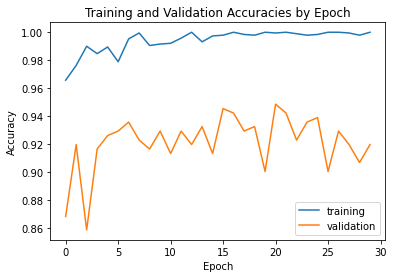

In [16]:
# Plot training with validation
plt.plot(range(epochs), train_acc_lst, label='training')
plt.plot(range(epochs), val_acc_lst, label='validation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracies by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

print(np.argmax(val_acc_lst))

In [19]:
# Loading best model parameters from file
best_epoch = 25
best_model_file_name = f'{model_save_path}/epoch{best_epoch}.params'
finetune_net.load_parameters(best_model_file_name, ctx=ctx)
# run on test data
_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.871


## Next

Now that you have learned to muster the power of transfer
learning, to learn more about training a model on
ImageNet, please read `this tutorial <dive_deep_imagenet.html>`__.

The idea of transfer learning is the basis of
`object detection <../examples_detection/index.html>`_ and
`semantic segmentation <../examples_segmentation/index.html>`_,
the next two chapters of our tutorial.

.. |image-minc| image:: https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png
.. |image-model| image:: https://zh.gluon.ai/_images/fine-tuning.svg

